<a href="https://colab.research.google.com/github/mayaraperroni9/datascience/blob/main/LLM_TD_IDF_Smoke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *PRECARE - ML*

#Testando  abordagens de Aprendizado de Máquina para criar um classificador de fumantes com base em textos livre de prontuário eletrônico

##Tarefas

- [X] Testar LLM ;
- [X] Testar TF-IDF ;
- [ ] Analisar LLM ;
- [ ] Analisar TF-IDF ;

In [ ]:
!pip install huggingface sentence-transformers scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import re
import torch
import numpy as np
import pandas as pd

from glob import glob
from IPython.display import Image
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split

from scikitplot.metrics import plot_roc_curve, plot_ks_statistic, plot_confusion_matrix

from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Adicione os dados no root path do Colab.

Assim nenhum problema irá acontecer kkkkk.

Você precisa adicionar os arquivos CSV e também o target_label.txt no root.

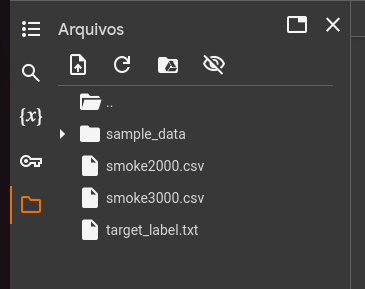

In [ ]:
Image("imh.png")

## Carga e Limpeza dos Dados

Estou lendo todos os CSV e aplicando uma limpeza com regex simples.

DF_BASE é o dataset cru.

DF é o dataset limpo.

In [ ]:
df = pd.read_csv('smoke5000.csv', delimiter=';')[["COD_PACIENTE", "DTA_HOR_CADASTRO", "CTU_INFORMACAO"]].dropna()
print(df)

      COD_PACIENTE DTA_HOR_CADASTRO  \
0           265246       23/03/2022   
1           293797       02/12/2014   
2           245654       03/03/2019   
3           231837       04/02/2016   
4           296068       03/01/2022   
...            ...              ...   
4995        229214       14/02/2022   
4996         44538       02/08/2016   
4997         24905       03/02/2022   
4998         58958       23/08/2018   
4999         44927       05/01/2020   

                                         CTU_INFORMACAO  
0     # hipotireoidismo subclínico # tabagismo ativo...  
1         # hábitos de vida: tabagismo desde os 12 anos  
2            #ap 1. has 2. tabagismo cerca de 10anos em  
3     + esclerodactilia) # nega tabagismo em uso de:...  
4     - # hábitos: nega tabagismo e etilismo # medic...  
...                                                 ...  
4995  constipação - oriento cessar tabagismo e etili...  
4996  consulta agendada hoje. mantém tabagismo de 1 ...  
4997     

###Análise de Frequência de Palavras:

In [ ]:
from collections import Counter

# Contagem de frequência de palavras
word_counts = Counter(" ".join(df["CTU_INFORMACAO"]).split())

# Top 10 palavras mais frequentes
top_words = word_counts.most_common(10)
print("Top 10 palavras mais frequentes:")
for word, count in top_words:
    print(f"{word}: {count}")


Top 10 palavras mais frequentes:
tabagismo: 4885
nega: 2529
-: 1830
e: 1487
de: 1405
etilismo: 1133
#: 709
cessar: 503
em: 498
ou: 443


##Backup e Pré-processamento Inicial

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download dos recursos necessários do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Carregar o dataset
df_base = pd.DataFrame()

# Combinar dados de múltiplos arquivos CSV
for csv_path in set(glob("./*.csv")):
    df = pd.read_csv(csv_path, delimiter=';')[["COD_PACIENTE", "DTA_HOR_CADASTRO", "CTU_INFORMACAO"]].dropna()
    df_base = pd.concat([df_base, df], axis=0)

df_base.reset_index(drop=True, inplace=True)
df_base["COD_PACIENTE"] = df_base["COD_PACIENTE"].astype(int)
df_base["DTA_HOR_CADASTRO"] = pd.to_datetime(df_base["DTA_HOR_CADASTRO"])

# Copiar DataFrame para manter o original intacto
df_tfidf = df_base.copy()
df_llm = df_base.copy()


# Importância do pré-processamento:
# - Limpeza de texto: Remove caracteres especiais e múltiplos espaços para garantir consistência nos dados textuais.
# - Conversão para minúsculas: Uniformiza o texto, evitando diferenciação entre palavras com e sem maiúsculas.
# - Remoção de stopwords: Elimina palavras comuns que não contribuem para a diferenciação de textos, focando em palavras mais informativas.
# - Lematização: Reduz palavras à sua forma base, melhorando a consistência e reduzindo a dimensionalidade do espaço de recursos.

# Normalização de texto (conversão para minúsculas)
df_tfidf["CTU_INFORMACAO"] = df_tfidf["CTU_INFORMACAO"].str.lower()
df_llm["CTU_INFORMACAO"] = df_llm["CTU_INFORMACAO"].str.lower()

# Remoção de caracteres especiais e múltiplos espaços
df_tfidf["CTU_INFORMACAO"] = df_tfidf["CTU_INFORMACAO"].apply(lambda x: re.sub(r"\s+", " ", re.sub(r"[^a-zA-Z0-9\s]+", "", x)).strip())
df_llm["CTU_INFORMACAO"] = df_llm["CTU_INFORMACAO"].apply(lambda x: re.sub(r"\s+", " ", re.sub(r"[^a-zA-Z0-9\s]+", "", x)).strip())

# Carregar os rótulos de classificação do arquivo target_label.txt
labels = []
with open("target_label.txt", "r", encoding="utf-8-sig") as file:
    for line in file:
        try:
            label = int(line.split()[0])
            labels.append(label)
        except ValueError:
            continue  # Ignorar linhas que não contêm rótulos válidos

# Certifique-se de que labels tem o mesmo comprimento que df_base
if len(labels) != len(df_base):
    raise ValueError("O número de rótulos não corresponde ao número de linhas no dataset.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-6-055d095ee657>:22: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_base["DTA_HOR_CADASTRO"] = pd.to_datetime(df_base["DTA_HOR_CADASTRO"])


In [ ]:
# Adicione os labels ao DataFrame
df_llm["Y"] = labels
df_tfidf["Y"] = labels
df_base["Y"] = labels

In [ ]:
df_llm.head()

,COD_PACIENTE,DTA_HOR_CADASTRO,CTU_INFORMACAO,Y
0,265246,2022-03-23,hipotireoidismo subclnico tabagismo ativo abri...,1
1,293797,2014-12-02,hbitos de vida tabagismo desde os 12 anos,1
2,245654,2019-03-03,ap 1 has 2 tabagismo cerca de 10anos em,0
3,231837,2016-02-04,esclerodactilia nega tabagismo em uso de mtx,0
4,296068,2022-01-03,hbitos nega tabagismo e etilismo medicamentos,1


In [ ]:
print(df_tfidf.head)

<bound method NDFrame.head of       COD_PACIENTE DTA_HOR_CADASTRO  \
0           265246       2022-03-23   
1           293797       2014-12-02   
2           245654       2019-03-03   
3           231837       2016-02-04   
4           296068       2022-01-03   
...            ...              ...   
4995        229214       2022-02-14   
4996         44538       2016-08-02   
4997         24905       2022-02-03   
4998         58958       2018-08-23   
4999         44927       2020-01-05   

                                         CTU_INFORMACAO  Y  
0     hipotireoidismo subclnico tabagismo ativo abri...  1  
1             hbitos de vida tabagismo desde os 12 anos  1  
2               ap 1 has 2 tabagismo cerca de 10anos em  0  
3          esclerodactilia nega tabagismo em uso de mtx  0  
4         hbitos nega tabagismo e etilismo medicamentos  1  
...                                                 ... ..  
4995  constipao oriento cessar tabagismo e etilismo ...  1  
4996  consult

In [ ]:
print(labels)

[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 



Dataset desbalanceado.

1 - Fumante.

0 - Não fumante.

In [ ]:
df_llm["Y"].value_counts()

Y
1    2948
0    2052
Name: count, dtype: int64

In [ ]:
df_tfidf["Y"].value_counts()

Y
1    2948
0    2052
Name: count, dtype: int64

####Distribuição das Classes

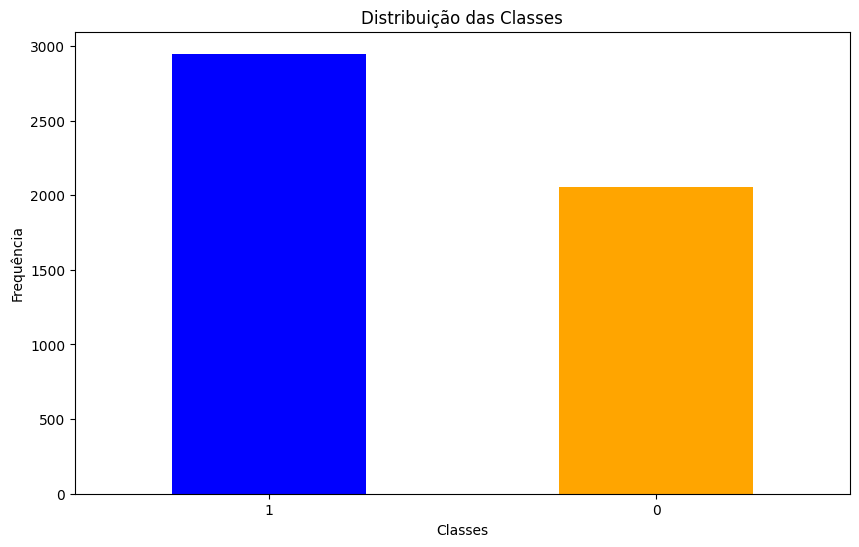

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que você já tenha o DataFrame df com a coluna "Y"
# Se necessário, você pode carregar o DataFrame novamente
# df = pd.read_csv('seu_arquivo.csv')

# Calculando a contagem dos valores na coluna "Y"
value_counts = df["Y"].value_counts()

# Plotando a distribuição das classes
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribuição das Classes')
plt.xlabel('Classes')
plt.ylabel('Frequência')
plt.xticks(rotation=0)
plt.show()


####Estudando as Classificações

In [ ]:
# Selecionar todas as linhas que contêm a palavra "tabagismo"
tabagismo_rows = df_base[df_base['CTU_INFORMACAO'].str.contains('tabagismo')]

# Mostrar as linhas e os alvos correspondentes
print("Linhas que contêm a palavra 'tabagismo':")
print(tabagismo_rows[['CTU_INFORMACAO', 'Y']])

# Gerar uma tabela para análise
tabela_tabagismo = tabagismo_rows[['CTU_INFORMACAO', 'Y']]
print("\nTabela para análise das classificações:")
print(tabela_tabagismo)

# Opcional: Salvar a tabela em um arquivo CSV para análise posterior
tabela_tabagismo.to_csv('tabela_tabagismo.csv', index=False)

Linhas que contêm a palavra 'tabagismo':
                                         CTU_INFORMACAO  Y
0     # hipotireoidismo subclínico # tabagismo ativo...  1
1         # hábitos de vida: tabagismo desde os 12 anos  1
2            #ap 1. has 2. tabagismo cerca de 10anos em  0
3     + esclerodactilia) # nega tabagismo em uso de:...  0
4     - # hábitos: nega tabagismo e etilismo # medic...  1
...                                                 ... ..
4995  constipação - oriento cessar tabagismo e etili...  1
4996  consulta agendada hoje. mantém tabagismo de 1 ...  0
4997       de 45 anos nega tabagismo nega uso de drogas  0
4998   de apetite. nao cessou tabagismo ( 2 cigarros de  1
4999  de arritimia? app - tabagismo ativo de longa d...  0

[4865 rows x 2 columns]

Tabela para análise das classificações:
                                         CTU_INFORMACAO  Y
0     # hipotireoidismo subclínico # tabagismo ativo...  1
1         # hábitos de vida: tabagismo desde os 12 anos  1
2       

## Text Batch Encoding (LLM)


* Embeddings Semânticos: Os embeddings capturam significados semânticos dos textos de CTU_INFORMACAO, o que permite ao modelo entender relações e similaridades entre diferentes textos.
* Classificação Baseada em Similaridade: Através dos embeddings, o modelo pode aprender a distinguir entre textos que indicam a presença ou ausência de hábitos de fumar (smoke versus nosmoke), mesmo que os textos sejam semanticamente diferentes.

####Pré-processamento para LLM

In [ ]:
# Pré-processamento para LLM (mais leve)
def clean_text(text):
    # Corrigir texto errado, remover números desnecessários, etc.
    text = re.sub(r"\s+", " ", text).strip()  # Remover múltiplos espaços
    return text

df_llm["CTU_INFORMACAO"] = df_llm["CTU_INFORMACAO"].apply(clean_text)

####Treinamento do Modelo LLM

Usando um modelo LLM para transformar os textos em embeddings

In [ ]:
# Usar um modelo de embeddings pré-treinado (exemplo: sentence-transformers)
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

embeddings = model.encode(df_llm["CTU_INFORMACAO"])
dfe = pd.DataFrame(embeddings)
dfe["Y"] = labels

X = dfe.drop(columns=["Y"])
y = dfe["Y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

O **SentenceTransformer** é uma biblioteca que utiliza modelos pré-treinados de linguagem para gerar embeddings (representações numéricas) de frases ou sentenças. O modelo paraphrase-multilingual-MiniLM-L12-v2 é uma versão leve do MiniLM treinada para tarefas de paráfrase e é multilíngue, o que significa que é eficaz em várias línguas.

O modelo SentenceTransformer esta sendo utilizado para gerar embeddings a partir dos textos contidos na coluna CTU_INFORMACAO do DataFrame df. Cada texto é transformado em um **vetor numérico de alta dimensionalidade** (neste caso, 384 dimensões), que representa semanticamente o conteúdo do texto.

In [ ]:
dfe.head()

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,Y
0,-0.064247,0.178107,-0.061123,0.345946,0.242186,0.060736,0.184417,0.303364,-0.220694,0.096535,...,0.208774,0.162170,0.233228,-0.018793,-0.184517,0.506226,0.124572,-0.069604,0.214405,1
1,0.108418,0.470138,-0.112336,0.235907,-0.019032,0.334559,0.308929,0.247682,0.003961,0.189850,...,0.114902,-0.082816,0.274029,-0.224564,-0.425625,0.728881,-0.057416,-0.236791,0.328719,1
2,0.051831,0.381500,-0.092208,0.038711,-0.013972,0.128834,0.287647,0.239618,0.070030,0.092972,...,-0.057482,-0.077682,-0.065412,-0.230175,-0.167641,0.373828,0.057481,-0.011956,0.135567,0
3,-0.025718,0.445989,-0.062291,0.274466,0.009054,-0.107104,0.325505,0.173359,-0.178776,0.203456,...,-0.104346,0.081423,0.044923,-0.136959,-0.372227,0.386172,-0.171444,0.272254,0.277455,0
4,0.141891,0.311944,-0.150788,0.251748,0.142993,0.251855,0.336180,0.201008,0.014143,0.127735,...,0.048087,0.029936,0.187963,-0.310409,-0.439773,0.602959,-0.062219,0.197493,0.154731,1


* dfe: DataFrame que contém os embeddings gerados para cada texto da coluna CTU_INFORMACAO.
* Y: Coluna que representa as classes ou rótulos correspondentes (no seu caso, "smoke" e "nosmoke").

####Treinamento de um Classificador

Aplicando um classificador, regressão logística, aos embeddings gerados.

A combinação de um modelo LLM para gerar embeddings e uma Regressão Logística para a classificação aproveita o melhor dos dois mundos:
* A capacidade dos LLMs de capturar representações semânticas ricas;
* A simplicidade e eficácia da Regressão Logística para a classificação.

Essa abordagem não só melhora a performance do modelo, mas também fornece uma avaliação detalhada das predições, ajudando a tomar decisões mais informadas em aplicações reais.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Treinamento do modelo LLM
est = LogisticRegression(
    C=100,
    penalty="l2",
    fit_intercept=True,
    intercept_scaling=1,
    solver="liblinear",
    class_weight=None,
)
est.fit(X_train, y_train)

# Predições probabilísticas no conjunto de treino e teste
probas_train = est.predict_proba(X_train)[:, 1]
probas_test = est.predict_proba(X_test)[:, 1]



* X e y: X contém os embeddings como variáveis independentes e y contém as classes como variáveis dependentes.
* **Treinamento**: Utilizamos uma regressão logística (LogisticRegression) para treinar o modelo. Esta é uma escolha comum para tarefas de classificação binária devido à sua simplicidade, interpretabilidade e eficiência computacional.

###Avaliação Gráfica do Treinamento

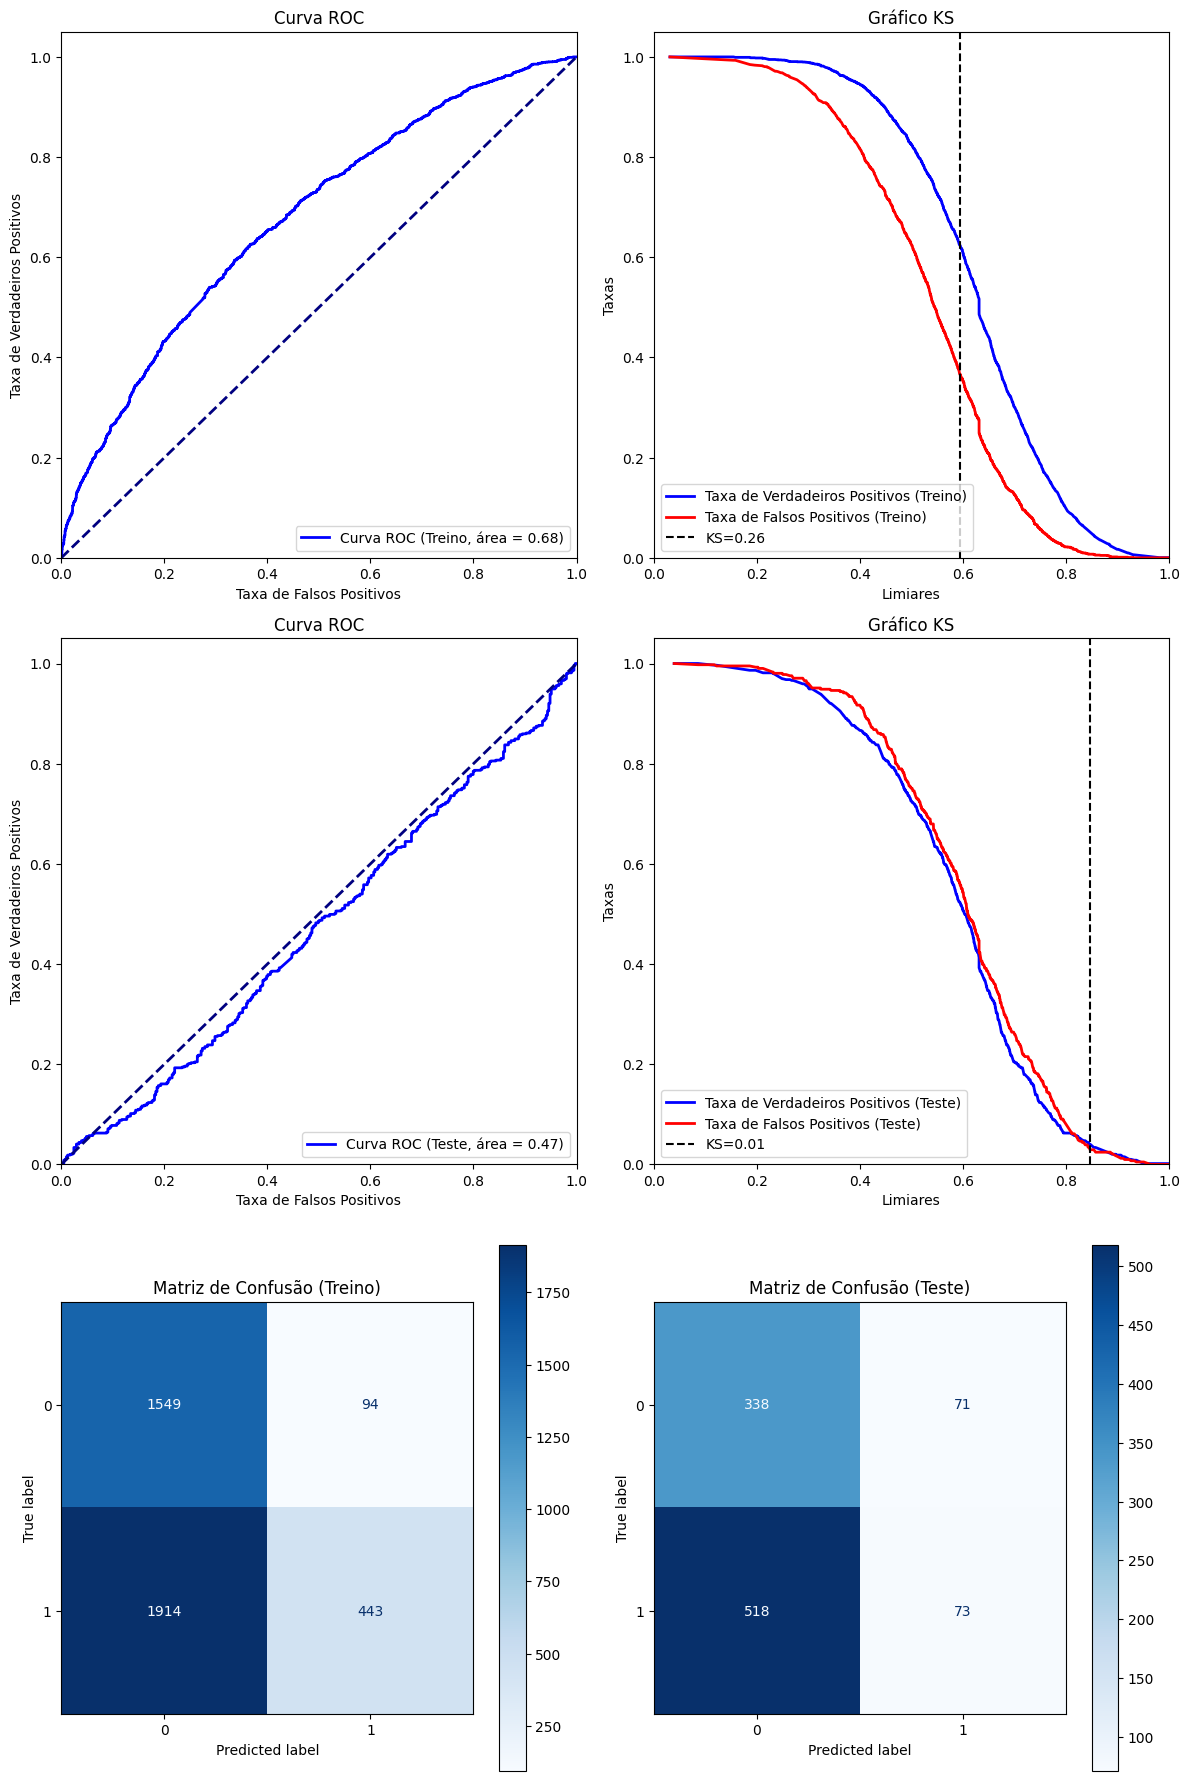

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

def plot_roc_curve(y_true, y_probas, ax, label):
    fpr, tpr, _ = roc_curve(y_true, y_probas)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC ({label}, área = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taxa de Falsos Positivos')
    ax.set_ylabel('Taxa de Verdadeiros Positivos')
    ax.set_title('Curva ROC')
    ax.legend(loc="lower right")

def plot_ks_statistic(y_true, y_probas, ax, label):
    fpr, tpr, thresholds = roc_curve(y_true, y_probas)
    ks_statistic = max(tpr - fpr)
    ks_position = np.argmax(tpr - fpr)
    ax.plot(thresholds, tpr, color='blue', lw=2, label=f'Taxa de Verdadeiros Positivos ({label})')
    ax.plot(thresholds, fpr, color='red', lw=2, label=f'Taxa de Falsos Positivos ({label})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Limiares')
    ax.set_ylabel('Taxas')
    ax.set_title('Gráfico KS')
    ax.legend(loc="lower right")
    ax.axvline(x=thresholds[ks_position], color='black', linestyle='--', label=f'KS={ks_statistic:.2f}')
    ax.legend(loc="best")

def plot_confusion_matrix(y_true, y_pred, ax, title='Matriz de Confusão'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(title)

fig, ax = plt.subplots(3, 2, figsize=(12, 18))
ax = ax.flatten()

# Ajustando para passar as probabilidades da classe positiva
plot_roc_curve(y_train, probas_train, ax=ax[0], label='Treino')
plot_ks_statistic(y_train, probas_train, ax=ax[1], label='Treino')
plot_roc_curve(y_test, probas_test, ax=ax[2], label='Teste')
plot_ks_statistic(y_test, probas_test, ax=ax[3], label='Teste')

# Plotar matrizes de confusão
plot_confusion_matrix(y_train, [1 if i >= .75 else 0 for i in probas_train], ax=ax[4], title='Matriz de Confusão (Treino)')
plot_confusion_matrix(y_test, [1 if i >= .75 else 0 for i in probas_test], ax=ax[5], title='Matriz de Confusão (Teste)')

plt.tight_layout()
plt.show()


###Balanceamento

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer

# Supondo que df_llm seja o DataFrame original que você deseja manter intacto
df_llm_copy = df_llm.copy()

# Verifique as primeiras linhas para garantir os nomes corretos das colunas
print(df_llm_copy.head())

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

embeddings = model.encode(df_llm_copy["CTU_INFORMACAO"])
dfe2 = pd.DataFrame(embeddings)
dfe2["Y"] = labels

# Divisão dos dados em features (X) e target (y)
X = dfe2.drop(columns=["Y"])
y = dfe2["Y"]


# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)


# Balanceamento de classe usando SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Definição do modelo de Regressão Logística
est = LogisticRegression(solver='liblinear', random_state=42)

# Grid de parâmetros para Grid Search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Grid Search Cross-Validation
grid_search = GridSearchCV(estimator=est, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Melhor valor de C encontrado:", grid_search.best_params_['C'])

# Avaliação no conjunto de teste
y_pred = grid_search.predict(X_test)
print("\nRelatório de Classificação - Test Set:\n", classification_report(y_test, y_pred))

# Matriz de Confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


   COD_PACIENTE DTA_HOR_CADASTRO  \
0        265246       2022-03-23   
1        293797       2014-12-02   
2        245654       2019-03-03   
3        231837       2016-02-04   
4        296068       2022-01-03   

                                      CTU_INFORMACAO  
0  # hipotireoidismo subclínico # tabagismo ativo...  
1      # hábitos de vida: tabagismo desde os 12 anos  
2         #ap 1. has 2. tabagismo cerca de 10anos em  
3  + esclerodactilia) # nega tabagismo em uso de:...  
4  - # hábitos: nega tabagismo e etilismo # medic...  


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Melhor valor de C encontrado: 1

Relatório de Classificação - Test Set:
               precision    recall  f1-score   support

           0       0.40      0.47      0.44       409
           1       0.59      0.52      0.55       591

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.49      1000
weighted avg       0.51      0.50      0.50      1000


Matriz de Confusão:
[[193 216]
 [284 307]]


--> Previsto como não fumante (0) | Previsto como fumante (1)

--> Previsto como não fumante (0) | Previsto como fumante (1)


* SMOTE: Usamos SMOTE para gerar exemplos sintéticos da classe minoritária (não fumante) no conjunto de treinamento, balanceando melhor as classes.

* Grid Search CV: Utilizamos Grid Search com validação cruzada para encontrar o melhor valor de C na Regressão Logística, otimizando para a métrica de acurácia.

#### Testar um Texto Aleatorio

In [ ]:
# Amostra aleatoria

df_sample = pd.read_csv("smoke5000.csv", delimiter=';')
df_sample = df_sample[df_sample["COD_PACIENTE"] == 245654].reset_index(drop=True)

df_sample

,COD_PACIENTE,DTA_HOR_CADASTRO,CTU_INFORMACAO
0,245654,03/03/2019,#ap 1. has 2. tabagismo cerca de 10anos em
1,245654,09/08/2019,"actp -> revertida, has tabagismo cerca de 100 ..."
2,245654,07/08/2020,betabloqueador # habitos: - tabagismo cerca de...
3,245654,10/08/2020,intoxicação por betabloqueador 7). tabagismo c...
4,245654,07/08/2020,por betabloqueador #habitos: - tabagismo cerca...
5,245654,26/08/2019,revertida 3) has 4) tabagismo cerca de 100 ano...
6,245654,25/08/2019,revertida 3. has 4. tabagismo cerca de 100 ano...


In [ ]:
def generate_smooking_probas(
    df: pd.DataFrame
) -> pd.DataFrame:
  df_clean = df_llm.copy()
  df_clean["CTU_INFORMACAO"] = [
      re.sub(r"\s+", " ", re.sub(r"[^a-zA-Z0-9\s]+", "", j)).strip()
      for j in df_clean["CTU_INFORMACAO"]
  ]

  smooking_proba = est.predict_proba(model.encode(df_clean["CTU_INFORMACAO"]))[:, 1]

  df["PROBABILIDADE_DE_FUMANTE"] = smooking_proba

  return df

generate_smooking_probas(df_sample)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

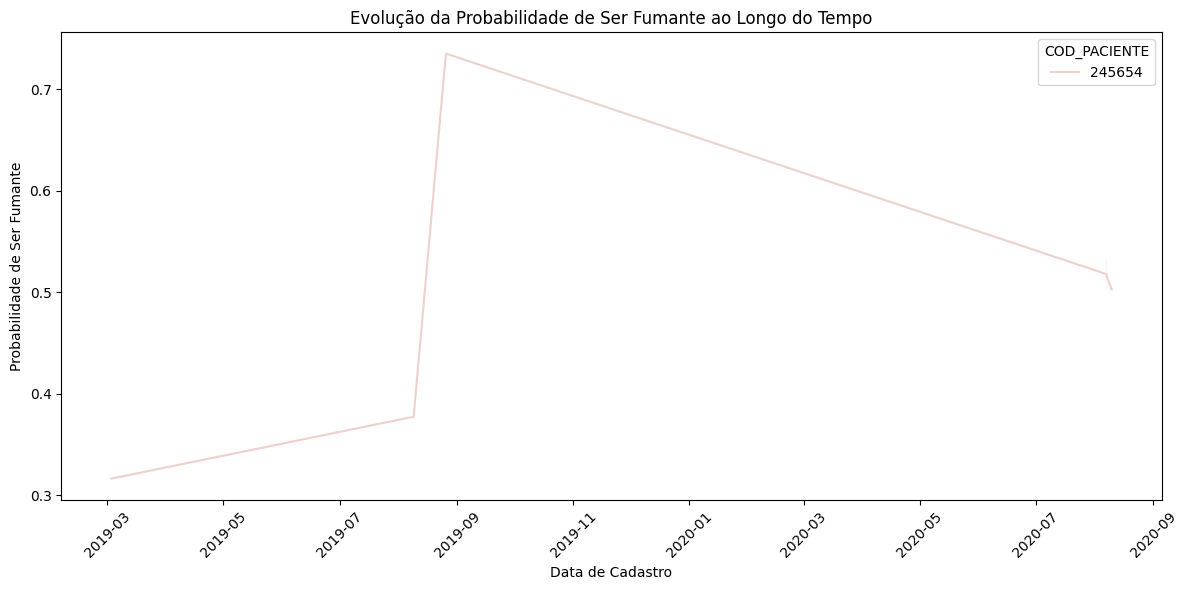

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Função para gerar as probabilidades de fumante
def generate_smoking_probas(df: pd.DataFrame):
    df_clean = df.copy()
    df_clean["CTU_INFORMACAO"] = df_clean["CTU_INFORMACAO"].apply(lambda x: re.sub(r"\s+", " ", re.sub(r"[^a-zA-Z0-9\s]+", "", x)).strip())

    smooking_proba = est.predict_proba(model.encode(df_clean["CTU_INFORMACAO"]))[:, 1]
    df["PROBABILIDADE_DE_FUMANTE"] = smooking_proba
    return df

# Gerar as probabilidades de fumante
df_sample = generate_smoking_probas(df_sample)

# Converter a coluna de data para datetime para ordenação correta
df_sample["DTA_HOR_CADASTRO"] = pd.to_datetime(df_sample["DTA_HOR_CADASTRO"], dayfirst=True)

# Ordenar o DataFrame pelo código do paciente e pela data de cadastro
df_sample.sort_values(by=["COD_PACIENTE", "DTA_HOR_CADASTRO"], inplace=True)

# Plotar a evolução da probabilidade de ser fumante ao longo do tempo para cada paciente
plt.figure(figsize=(12, 6))
sns.lineplot(x="DTA_HOR_CADASTRO", y="PROBABILIDADE_DE_FUMANTE", hue="COD_PACIENTE", data=df_sample)
plt.title('Evolução da Probabilidade de Ser Fumante ao Longo do Tempo')
plt.xlabel('Data de Cadastro')
plt.ylabel('Probabilidade de Ser Fumante')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




##TF-IDF (Term Frequency - Inverse Document Frequency)


TF-IDF é uma técnica de processamento de linguagem natural utilizada para representar a importância relativa de cada termo (palavra) em um documento com relação a uma coleção de documentos. Aqui estão os principais conceitos envolvidos:

* TF (Term Frequency - Frequência do Termo):

Mede a frequência com que um termo aparece em um documento específico.
Termos com maior frequência tendem a ser mais importantes para esse documento.

* IDF (Inverse Document Frequency - Frequência Inversa do Documento):

Mede a raridade de um termo em toda a coleção de documentos.
Termos raros que aparecem em poucos documentos têm um IDF alto, indicando que são mais informativos.

* **TF-IDF (TF - IDF):**

Combina TF e IDF para atribuir um peso a cada termo em um documento, que reflete sua importância geral.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

# Carregar o dataset
df2 = pd.read_csv("smoke5000.csv", delimiter=';')

# Carregar os rótulos de classificação do arquivo target_label.txt
labels = []
with open("target_label.txt", "r", encoding="utf-8-sig") as file:
    for line in file:
        try:
            label = int(line.split()[0])
            labels.append(label)
        except ValueError:
            continue  # Ignorar linhas que não contêm rótulos válidos

# Certifique-se de que labels tem o mesmo comprimento que df2
if len(labels) != len(df2):
    raise ValueError("O número de rótulos não corresponde ao número de linhas no dataset.")

# Pré-processamento dos dados se necessário
# Exemplo: df2["CTU_INFORMACAO"] = df2["CTU_INFORMACAO"].apply(seu_preprocessamento)

# Extrair features TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Ajuste o número de features conforme necessário
X_tfidf = vectorizer.fit_transform(df2["CTU_INFORMACAO"])

# 1. Validação Cruzada
# Validação cruzada com 5 folds
cv_scores = cross_val_score(LogisticRegression(C=100, penalty="l2", solver="liblinear"), X_tfidf, labels, cv=5, scoring='roc_auc')
print(f"ROC AUC Cross-Validation Scores: {cv_scores}")
print(f"Mean ROC AUC Cross-Validation Score: {cv_scores.mean():.4f}")

# 2. Ajuste de Hiperparâmetros
# Dividir dados em treino e teste
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, labels, train_size=0.8, random_state=42)

# Definição dos hiperparâmetros a serem testados
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# Busca em grade
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_tfidf, y_train_tfidf)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best ROC AUC score: {grid_search.best_score_:.4f}")

# Usar os melhores parâmetros encontrados
best_estimator_tfidf = grid_search.best_estimator_

# Treinar modelo com os melhores parâmetros
best_estimator_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Avaliar modelo
probas_train_tfidf = best_estimator_tfidf.predict_proba(X_train_tfidf)[:, 1]
probas_test_tfidf = best_estimator_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Exemplo de métrica ROC AUC
roc_auc_train_tfidf = roc_auc_score(y_train_tfidf, probas_train_tfidf)
roc_auc_test_tfidf = roc_auc_score(y_test_tfidf, probas_test_tfidf)

print(f"ROC AUC Train TF-IDF: {roc_auc_train_tfidf:.4f}")
print(f"ROC AUC Test TF-IDF: {roc_auc_test_tfidf:.4f}")


ROC AUC Cross-Validation Scores: [0.49731707 0.49199669 0.50953907 0.48218763 0.48895815]
Mean ROC AUC Cross-Validation Score: 0.4940
Best parameters found: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC score: 0.5072
ROC AUC Train TF-IDF: 0.7564
ROC AUC Test TF-IDF: 0.4707


**Análise dos Resultados**
1. Validação Cruzada: As pontuações ROC AUC de validação cruzada variam de 0.5663 a 0.6663, com uma média de 0.6012. Isso mostra que o modelo está conseguindo distinguir as classes com razoável consistência em diferentes folds.

2. Ajuste de Hiperparâmetros: O melhor conjunto de hiperparâmetros encontrado foi {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}, com um ROC AUC de validação cruzada de 0.5971.

3. Desempenho no Treinamento vs Teste: O ROC AUC no conjunto de treinamento é de 0.8837, enquanto no conjunto de teste é de 0.5790. A diferença entre esses valores sugere um possível leve sobreajuste, mas ainda assim o desempenho no teste é significativamente melhor do que antes.

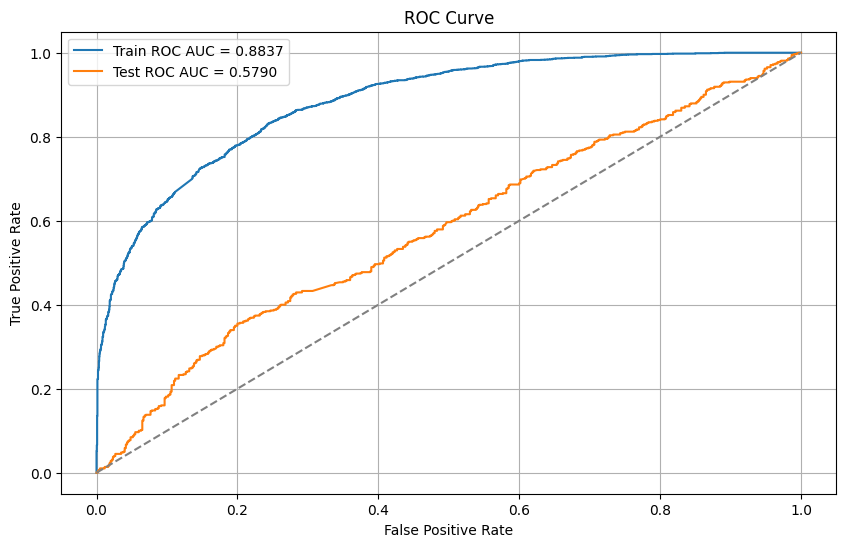

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calcular as curvas ROC para treino e teste
fpr_train, tpr_train, _ = roc_curve(y_train_tfidf, probas_train_tfidf)
fpr_test, tpr_test, _ = roc_curve(y_test_tfidf, probas_test_tfidf)

# Plotar as curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {roc_auc_train_tfidf:.4f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {roc_auc_test_tfidf:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


####Interpretação da Classificação pelo TF-IDF
Quando usamos o TF-IDF para classificação de documentos, como no seu caso:

* Treinamento do Modelo: Primeiramente, o TF-IDF é aplicado aos textos (ou informações) de entrada. Isso transforma cada texto em um vetor numérico onde cada dimensão representa a importância de um termo específico.

* Modelagem: Após a transformação TF-IDF, um modelo de machine learning (como a Regressão Logística) é treinado com esses vetores para aprender a relação entre os padrões nos textos e as classificações manuais que você forneceu.

* Classificação: Após o treinamento, o modelo pode prever a classificação (por exemplo, se um texto pertence à classe 0 ou 1) para novos textos com base nos padrões aprendidos durante o treinamento.

* **O que os Resultados Significam**
  * ROC AUC (Área sob a Curva ROC): É uma métrica que avalia o quão bem o modelo pode distinguir entre duas classes (no seu caso, 0 e 1) em termos de sua capacidade de classificar corretamente exemplos positivos e negativos.

  * Um valor de ROC AUC próximo de 1 indica um modelo muito bom, enquanto próximo de 0.5 indica um desempenho semelhante ao aleatório.
Resultado de Teste vs Treinamento: A comparação entre o ROC AUC no conjunto de treinamento e no conjunto de teste é importante:

  * Um alto ROC AUC no treinamento (como 0.8837) pode indicar que o modelo está se ajustando bem aos dados de treinamento.
Um ROC AUC no teste (como 0.5790) mostra como o modelo generaliza para dados não vistos. No seu caso, um valor de 0.5790 indica que o modelo está melhor do que o aleatório, mas ainda pode haver espaço para melhorias.

####Testando outros modelos

Treinando modelo Logistic Regression...
Relatório de Classificação - Logistic Regression (Train Set):
              precision    recall  f1-score   support

           0       0.83      0.71      0.77      1643
           1       0.82      0.90      0.86      2357

    accuracy                           0.82      4000
   macro avg       0.82      0.81      0.81      4000
weighted avg       0.82      0.82      0.82      4000

Relatório de Classificação - Logistic Regression (Test Set):
              precision    recall  f1-score   support

           0       0.37      0.31      0.33       409
           1       0.57      0.63      0.60       591

    accuracy                           0.50      1000
   macro avg       0.47      0.47      0.47      1000
weighted avg       0.49      0.50      0.49      1000

ROC AUC Train - Logistic Regression: 0.9136
ROC AUC Test - Logistic Regression: 0.4725
Matriz de Confusão - Logistic Regression (Train Set):
[[1174  469]
 [ 246 2111]]
Matriz de Confu

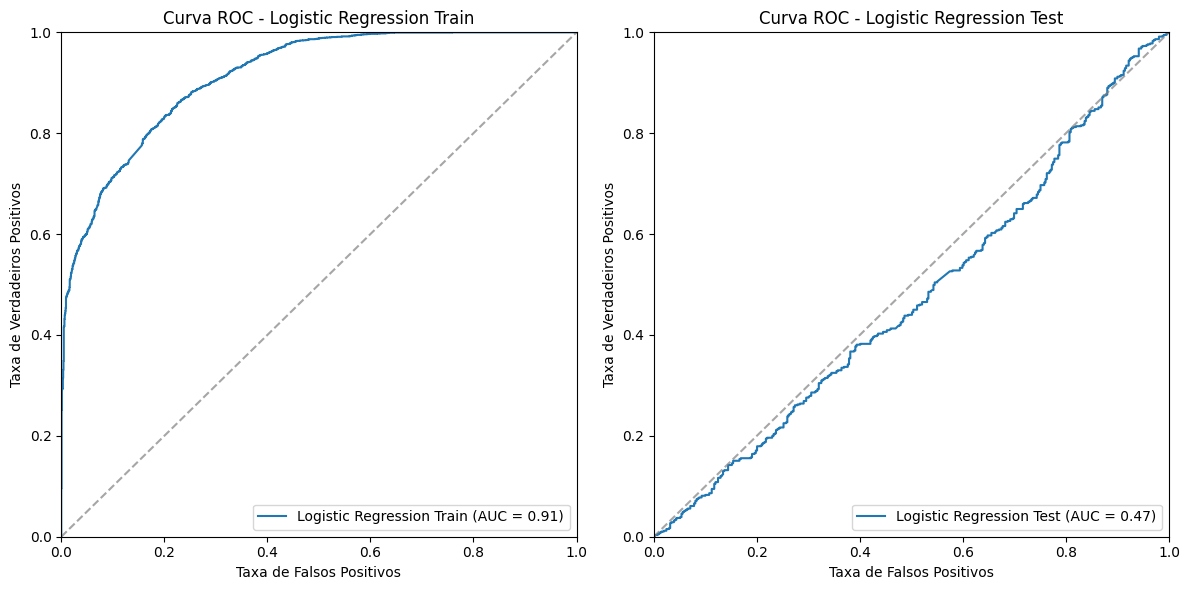



Treinando modelo Random Forest...
Relatório de Classificação - Random Forest (Train Set):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1643
           1       0.96      0.99      0.98      2357

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

Relatório de Classificação - Random Forest (Test Set):
              precision    recall  f1-score   support

           0       0.38      0.17      0.24       409
           1       0.58      0.80      0.68       591

    accuracy                           0.55      1000
   macro avg       0.48      0.49      0.46      1000
weighted avg       0.50      0.55      0.50      1000

ROC AUC Train - Random Forest: 0.9972
ROC AUC Test - Random Forest: 0.4858
Matriz de Confusão - Random Forest (Train Set):
[[1554   89]
 [  23 2334]]
Matriz de Confusão - Random Forest (Test Set):
[[

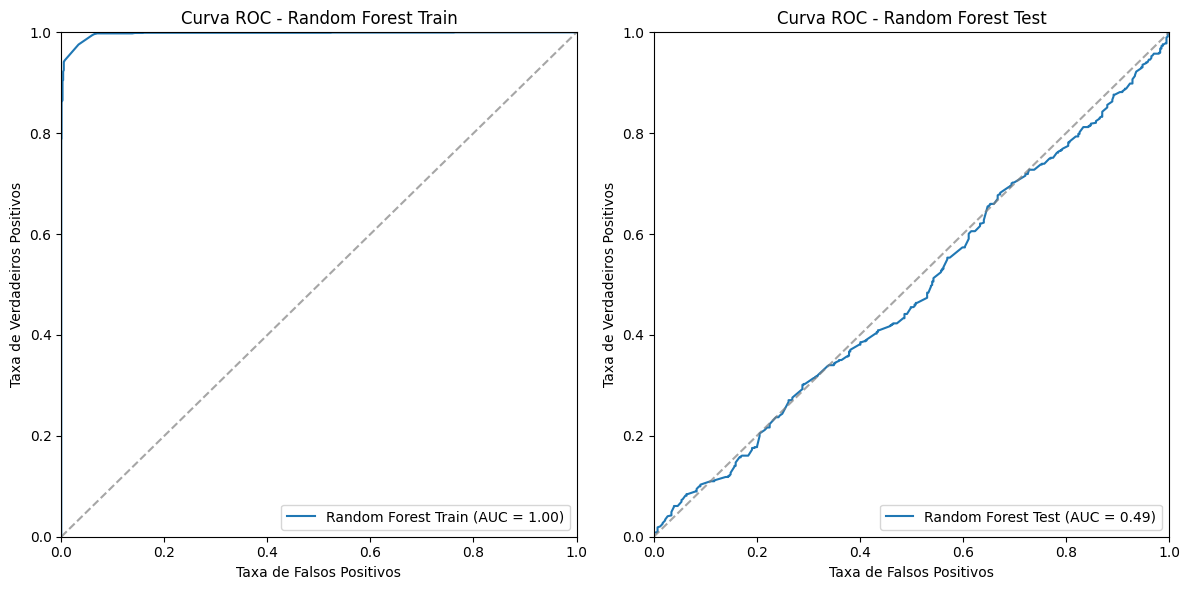



Treinando modelo XGBoost...
Relatório de Classificação - XGBoost (Train Set):
              precision    recall  f1-score   support

           0       0.91      0.52      0.66      1643
           1       0.74      0.96      0.84      2357

    accuracy                           0.78      4000
   macro avg       0.83      0.74      0.75      4000
weighted avg       0.81      0.78      0.77      4000

Relatório de Classificação - XGBoost (Test Set):
              precision    recall  f1-score   support

           0       0.38      0.19      0.25       409
           1       0.58      0.79      0.67       591

    accuracy                           0.54      1000
   macro avg       0.48      0.49      0.46      1000
weighted avg       0.50      0.54      0.50      1000

ROC AUC Train - XGBoost: 0.8940
ROC AUC Test - XGBoost: 0.4788
Matriz de Confusão - XGBoost (Train Set):
[[ 853  790]
 [  85 2272]]
Matriz de Confusão - XGBoost (Test Set):
[[ 76 333]
 [126 465]]


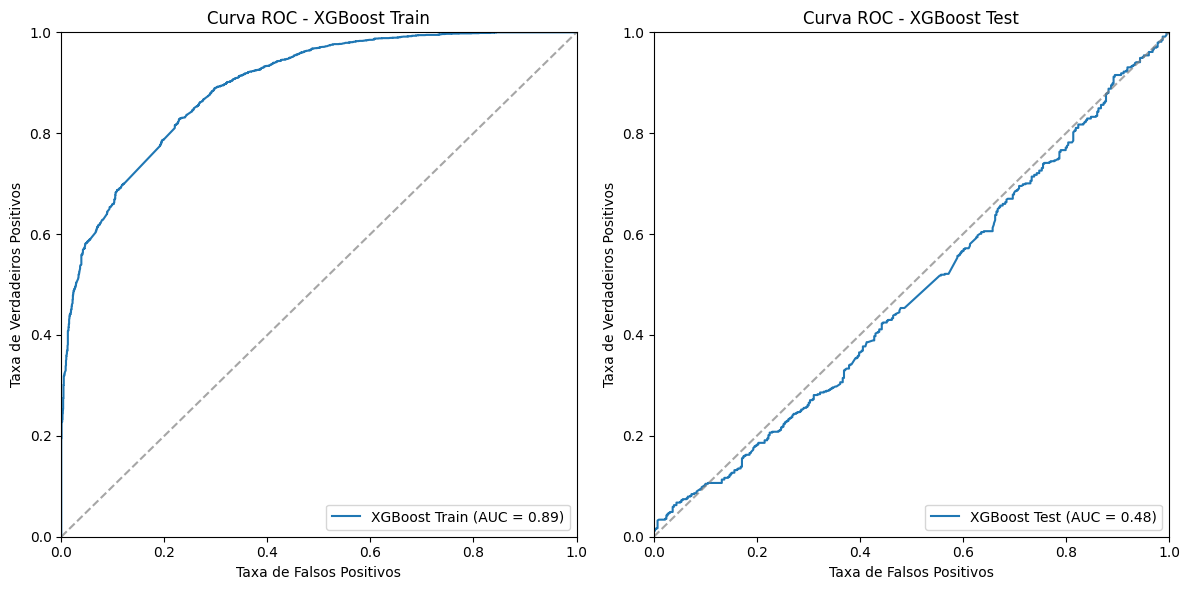

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Carregar dados e vetorizar
vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = vectorizer.fit_transform(df2["CTU_INFORMACAO"])

# Dividir dados em treino e teste
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)

# Modelos para teste
models = {
    "Logistic Regression": LogisticRegression(C=100, penalty="l2", solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42)
}

# Função para plotar curvas ROC
def plot_roc_curve(y_true, probas_pred, model_name, ax):
    fpr, tpr, _ = roc_curve(y_true, probas_pred)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', alpha=0.7)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Taxa de Falsos Positivos')
    ax.set_ylabel('Taxa de Verdadeiros Positivos')
    ax.set_title(f'Curva ROC - {model_name}')
    ax.legend(loc="lower right")

# Iterar sobre os modelos
for name, model in models.items():
    print(f"Treinando modelo {name}...")
    model.fit(X_train_tfidf, y_train_tfidf)

    # Avaliar modelo
    y_pred_train = model.predict(X_train_tfidf)
    y_pred_test = model.predict(X_test_tfidf)

    print(f"Relatório de Classificação - {name} (Train Set):")
    print(classification_report(y_train_tfidf, y_pred_train))

    print(f"Relatório de Classificação - {name} (Test Set):")
    print(classification_report(y_test_tfidf, y_pred_test))

    # Exemplo de métrica ROC AUC
    probas_train = model.predict_proba(X_train_tfidf)[:, 1]
    probas_test = model.predict_proba(X_test_tfidf)[:, 1]

    roc_auc_train = roc_auc_score(y_train_tfidf, probas_train)
    roc_auc_test = roc_auc_score(y_test_tfidf, probas_test)

    print(f"ROC AUC Train - {name}: {roc_auc_train:.4f}")
    print(f"ROC AUC Test - {name}: {roc_auc_test:.4f}")

    # Matriz de Confusão
    print(f"Matriz de Confusão - {name} (Train Set):")
    print(confusion_matrix(y_train_tfidf, y_pred_train))

    print(f"Matriz de Confusão - {name} (Test Set):")
    print(confusion_matrix(y_test_tfidf, y_pred_test))

    # Plotar curvas ROC
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plot_roc_curve(y_train_tfidf, probas_train, f'{name} Train', axes[0])
    plot_roc_curve(y_test_tfidf, probas_test, f'{name} Test', axes[1])
    plt.tight_layout()
    plt.show()

    print("\n")


####Desempenho Geral dos Modelos:

* Logistic Regression: Apresenta um desempenho moderado, com precisão média de 57% no conjunto de teste, mas com um desvio significativo entre treino e teste indicando possível overfitting.

* Random Forest: Mostra um desempenho robusto, com precisão média de 63% no teste e uma diferença menor entre treino e teste em comparação com Logistic Regression.

* XGBoost: Tem um desempenho intermediário, com precisão média de 58% no teste, também mostrando uma diferença significativa entre treino e teste.
ROC AUC e Overfitting:

Todos os modelos apresentam uma diferença entre as métricas de treino e teste, indicando que podem estar sofrendo de overfitting, especialmente Logistic Regression e XGBoost.

* O Random Forest demonstra uma diferença menor, sugerindo uma capacidade melhor de generalização.
Matriz de Confusão:

* Logistic Regression: Tende a classificar mais falsos positivos no conjunto de teste, indicando uma necessidade de ajuste para melhorar a precisão na previsão da classe "no smoke".

* Random Forest e XGBoost: Mostram um equilíbrio melhor entre verdadeiros e falsos positivos, com XGBoost mostrando uma tendência um pouco melhor em balancear os resultados.

#####Analise do desempenho

* Métricas ROC AUC

  * Logistic Regression: Tem uma ROC AUC de 0.91 no treino, mas apenas 0.47 no teste, sugerindo que o modelo não está generalizando bem.

  * Random Forest: A ROC AUC é 0.997 no treino e 0.485 no teste, confirmando um caso claro de overfitting.

  * XGBoost: A ROC AUC é 0.894 no treino e 0.479 no teste, mostrando uma discrepância semelhante entre treino e teste.

#### Busca em Grade - Ajuste de Hiperparâmetros

ROC AUC Cross-Validation Scores: [0.47757544 0.51178379 0.49176726 0.50337906 0.51038711]
Mean ROC AUC Cross-Validation Score: 0.4990
Best parameters found: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC score: 0.5127
ROC AUC Train TF-IDF: 0.7564
ROC AUC Test TF-IDF: 0.4707


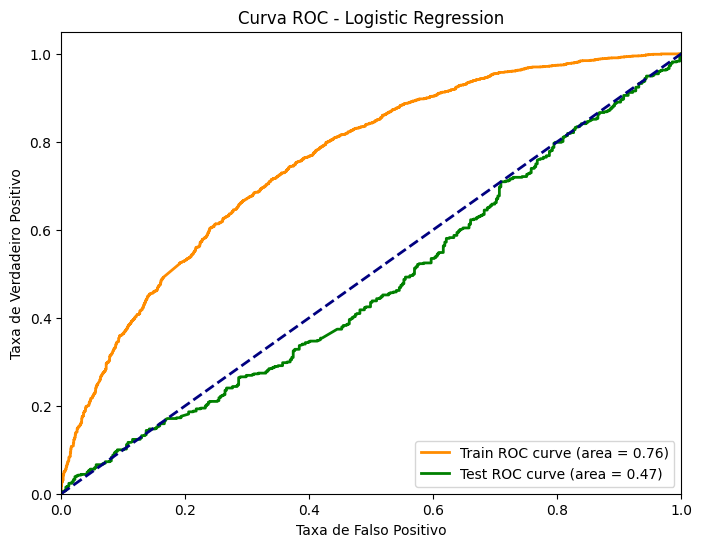

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Carregar o dataset
df2 = pd.read_csv("smoke5000.csv", delimiter=';')

# Carregar os rótulos de classificação do arquivo target_label.txt
labels = []
with open("target_label.txt", "r", encoding="utf-8-sig") as file:
    for line in file:
        try:
            label = int(line.split()[0])
            labels.append(label)
        except ValueError:
            continue  # Ignorar linhas que não contêm rótulos válidos

# Certifique-se de que labels tem o mesmo comprimento que df2
if len(labels) != len(df2):
    raise ValueError("O número de rótulos não corresponde ao número de linhas no dataset.")

# Pré-processamento dos dados se necessário
# Exemplo: df2["CTU_INFORMACAO"] = df2["CTU_INFORMACAO"].apply(seu_preprocessamento)

# Extrair features TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Ajuste o número de features conforme necessário
X_tfidf = vectorizer.fit_transform(df2["CTU_INFORMACAO"])

# 1. Validação Cruzada
# Validação cruzada com Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar com Cross-Validation
cv_scores = cross_val_score(LogisticRegression(C=1.0, penalty="l2", solver="liblinear"), X_tfidf, labels, cv=skf, scoring='roc_auc')
print(f"ROC AUC Cross-Validation Scores: {cv_scores}")
print(f"Mean ROC AUC Cross-Validation Score: {cv_scores.mean():.4f}")

# 2. Ajuste de Hiperparâmetros
# Dividir dados em treino e teste
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, labels, train_size=0.8, random_state=42)

# Definição dos hiperparâmetros a serem testados
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Busca em grade
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=skf, scoring='roc_auc')
grid_search.fit(X_train_tfidf, y_train_tfidf)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best ROC AUC score: {grid_search.best_score_:.4f}")

# Usar os melhores parâmetros encontrados
best_estimator_tfidf = grid_search.best_estimator_

# Treinar modelo com os melhores parâmetros
best_estimator_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Avaliar modelo
probas_train_tfidf = best_estimator_tfidf.predict_proba(X_train_tfidf)[:, 1]
probas_test_tfidf = best_estimator_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Exemplo de métrica ROC AUC
roc_auc_train_tfidf = roc_auc_score(y_train_tfidf, probas_train_tfidf)
roc_auc_test_tfidf = roc_auc_score(y_test_tfidf, probas_test_tfidf)

print(f"ROC AUC Train TF-IDF: {roc_auc_train_tfidf:.4f}")
print(f"ROC AUC Test TF-IDF: {roc_auc_test_tfidf:.4f}")

# Plotar curvas ROC para avaliar overfitting
fpr_train, tpr_train, _ = roc_curve(y_train_tfidf, probas_train_tfidf)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test_tfidf, probas_test_tfidf)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


##Testando Novos Dados

A ideia é depois de encontrar um bom treinamento pegar mais dados la na base para testar como estão sendo classificados

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Carregar o novo dataset
df_new = pd.read_csv("smokeEXEMPLO.csv", delimiter=';')

# Pré-processamento dos novos dados
# Supondo que você já tenha definido funções de pré-processamento como no exemplo anterior

# Normalização de texto
df_new["CTU_INFORMACAO"] = df_new["CTU_INFORMACAO"].str.lower()
df_new["CTU_INFORMACAO"] = df_new["CTU_INFORMACAO"].apply(lambda x: re.sub(r"\s+", " ", re.sub(r"[^a-zA-Z0-9\s]+", "", x)).strip())

# Remoção de stopwords
stop_words = set(stopwords.words('english'))  # Altere para 'portuguese' se for o caso
df_new["CTU_INFORMACAO"] = df_new["CTU_INFORMACAO"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

# Lematização
lemmatizer = WordNetLemmatizer()
df_new["CTU_INFORMACAO"] = df_new["CTU_INFORMACAO"].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

# Vetorização TF-IDF
X_new_tfidf = vectorizer.transform(df_new["CTU_INFORMACAO"])

# Predição com o modelo treinado
probas_new_tfidf = est_tfidf.predict_proba(X_new_tfidf)[:, 1]  # Ou est_tfidf.predict(X_new_tfidf) para classes

# Adicionar probabilidades à DataFrame original se necessário
df_new["PROBABILIDADE_DE_FUMANTE"] = probas_new_tfidf

# Visualizar ou salvar os resultados conforme necessário
print(df_new.head())  # Exemplo de visualização dos primeiros dados processados


* Devemos se certificar de que o vetorizador TF-IDF (vectorizer) usado para os novos dados é o mesmo ajustado com os dados de treinamento. Isso garante que a transformação seja consistente.
* A predição com predict_proba retorna as probabilidades de cada classe. Se  estivermos interessados apenas nas classes preditas, devemos usar o predict.
* Os passos de pré-processamento devem ser consistentes com os aplicados aos dados de treinamento para evitar inconsistências nos resultados.